# Przewidywanie typów gwiazd

Naszym celem będzie stworzenie modelu zdolnego do przewidywania typu gwiazdy na podstawie kilku atrybutów opisowych. Będziemy testować 4 różne klasyfikatory: najbliższych sąsiadów, prototypów, naiwny Bayesa oraz drzew decyzyjnych.

Temat projektu jest bazowany na zbiorze danych stworzonych przez jednego z użytkowników serwisu https://www.kaggle.com/ - Deepraj Baidya. Opis danych stworzony przez twórcę zestawu znajduje się na stronie https://www.kaggle.com/deepu1109/star-dataset.

### Potrzebne pakiety

Do analizy danych i stworzenia modelu przewidującego typ gwiazd będziemy używać następujących pakietów.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# do skalowania danych
from sklearn.preprocessing import StandardScaler
# do zamiany atrybutów kategorycznych na ilościowe
from sklearn.preprocessing import OrdinalEncoder
# podział zbioru danych na dane treningowe i testowe
from sklearn.model_selection import train_test_split
# testowane klasyfikatory
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

## Zestaw danych

Zestaw danych składa się z 240 rekordów. Każdy z nich zawiera 6 cech opisowych oraz 1 atrybut decyzyjny - typ gwiazdy. Większość danych została wstawiona z informacji o gwiazdach znalezionych w internecie. Część braków została uzupełniona za pomocą równań astronomicznych (tak napisał autor).

In [2]:
stars_raw = pd.read_csv('6 class csv.csv')
print(stars_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
 6   Spectral Class          240 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.2+ KB
None


4 z 7 atrybutów są ilościowe. Atrybutami kategorycznymi są: typ gwiazdy, kolor gwiazdy oraz klasa spektralna.

In [3]:
print(stars_raw.isna().sum())

Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64


Brak pustych pól - każdy rekord posiada pełny zestaw atrybutów.

### Temperatura

Pierwszym atrybutem jest temperatura gwiazdy podana w Kelwinach. Wartości mieszczą się w zakresie 1939 - 40000. Z histogramu możemy wyczytać, że duża część danych znajduje się przy granicy zakresu. Z tego wynika, że do wizualizacji tych danych warto będzie używać skali logarytmicznej.

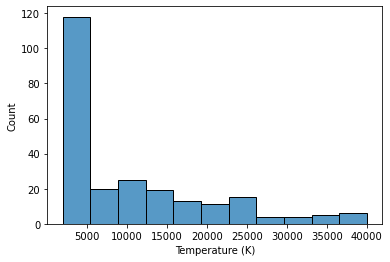

min: 1939, max: 40000


In [4]:
sns.histplot(stars_raw['Temperature (K)'])
plt.show()
print("min:", str(stars_raw['Temperature (K)'].min()) + ", max:", stars_raw['Temperature (K)'].max())

### Jasność

Drugim atrybutem jest względna jasność gwiazdy. Jest on jednostkowany wielokrotnością jasności Słońca (L/Lo). Tak jak w przypadku rozkładu temperatury, duża część danych znajduje się przy granicy zakresu - też warto użyć skali logarytmicznej.

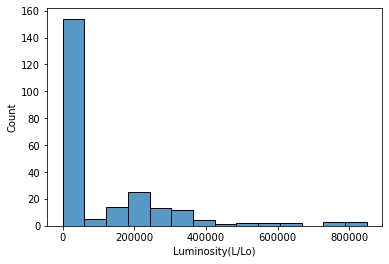

min: 8e-05, max: 849420.0


In [5]:
sns.histplot(stars_raw['Luminosity(L/Lo)'])
plt.show()
print("min:", str(stars_raw['Luminosity(L/Lo)'].min()) + ", max:", stars_raw['Luminosity(L/Lo)'].max())

### Promień

Trzecim atrybutem jest względny promień gwiazdy. Jest on określony jako stosunek promienia gwiazdy do promienia Słońca. 

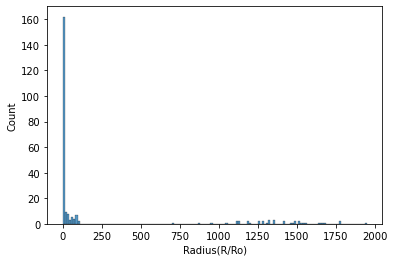

min: 0.0084, max: 1948.5


In [6]:
sns.histplot(stars_raw['Radius(R/Ro)'])
plt.show()
print("min:", str(stars_raw['Radius(R/Ro)'].min()) + ", max:", stars_raw['Radius(R/Ro)'].max())

### Abolutna wielkość gwiazdowa

Jest to maira wielkości gwiazdy liczona z ustalonej odległości 10 parseków. Wartości te mają charakter logarytmiczny, dlatego skala posiada zarówno wartości dodatnie jak i ujemne.

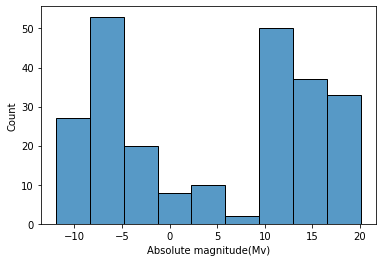

min: -11.92, max: 20.06


In [7]:
sns.histplot(stars_raw['Absolute magnitude(Mv)'])
plt.show()
print("min:", str(stars_raw['Absolute magnitude(Mv)'].min()) + ", max:", stars_raw['Absolute magnitude(Mv)'].max())

### Kolor

Pierwszym atrybutem kategorycznym jest kolor gwiazdy. Jest on opisany za pomocą słów. Co więcej część nazw jest bardzo podobna do siebie - różnią się tylko np. kolejnością kolorów, wielkością liter, dodatkowym znakiem spacji.

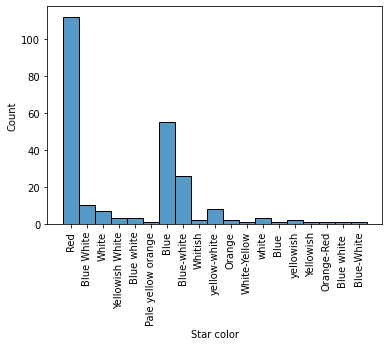

Kolory gwiazd ( 19 ):
	|Red|
	|Blue White|
	|White|
	|Yellowish White|
	|Blue white|
	|Pale yellow orange|
	|Blue|
	|Blue-white|
	|Whitish|
	|yellow-white|
	|Orange|
	|White-Yellow|
	|white|
	|Blue |
	|yellowish|
	|Yellowish|
	|Orange-Red|
	|Blue white |
	|Blue-White|


In [8]:
plt.xticks(rotation=90)
sns.histplot(stars_raw['Star color'])
plt.show()
colors = stars_raw['Star color'].unique()
print('Kolory gwiazd (', len(colors), '):')
for c in colors:
    print('\t|' + c + '|')

### Klasa spektralna

Inaczej zwana typem widmowym lub spektrum widma gwiazdy. Został podzielony przez naukowców do 7 kategorii które pozwalają na oszacowanie temperatury, składu chemicznego oraz ciśnienia powierzchniowego gwiazdy a także masy i szacowanego promienia gwiazdy. W obecnej astronomii jest głównym źródłem wiedzy na temat odległych gwiazd.

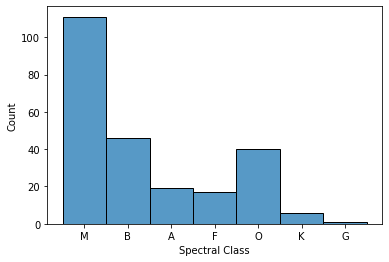

Klasy spektralne: ['M' 'B' 'A' 'F' 'O' 'K' 'G']
Liczba klas spektralnych: 7


In [9]:
sns.histplot(stars_raw['Spectral Class'])
plt.show()
print('Klasy spektralne:', stars_raw['Spectral Class'].unique())
print('Liczba klas spektralnych:', len(stars_raw['Spectral Class'].unique()))

### Typ gwiazdy

Atrybutem decyzyjnym jest typ gwiazdy. Jest on oznaczany poprzez wartość liczbową od 0 do 5. Rozkład tego atrybutu jest idealnie równy - każda kategoria posiada dokładnie 40 obiektów.
* Typ 0 oznacza brązowego karła który jest połączeniem pasma głównego gwiazd z pasmem karłów
* Typ 1 oznacza czerwonego karła, jest to etap przejściowy gwiazdy z pasma głównego do pasma karłów
* Typ 2 oznacza białe karły, czyli gwiazdy o zbyt małej masie aby doprowadzić do reakcji termojądrowych
* Typ 3 oznacza ciąg główny gwiazd, są to wszystkie gwiay w swojej głównej części życia. Należy do nich słońce.
* Typ 4 oznacza olbrzymy jest to etap przejściowy zwany schyłkiem ewolucji gwiazd z ciągu głównego.
* Typ 5 oznacza nadolbrzymy i hiperolbrzymy najmasywniejsze i najkrócej żyjące gwiazdy, przemieniają sie w czarne dziury lub gwiazdy neutronwe

Typy gwiazd: [0 1 2 3 4 5]
Liczba typów gwiazd: 6


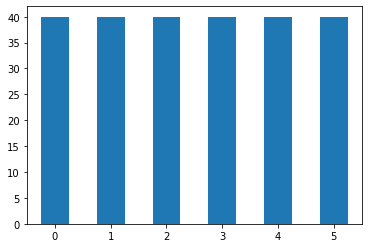

In [10]:
stars_raw['Star type'].value_counts().plot(kind='bar', rot=90)
plt.xticks(rotation='horizontal')
print('Typy gwiazd:', stars_raw['Star type'].unique())
print('Liczba typów gwiazd:', len(stars_raw['Star type'].unique()))

## Przygotowanie danych

Aby utworzyć poprawne i dokładne modele klasyfikatorów, dane powinny zostać wcześniej w odpowiedni sposób przygotowane.

### Podział argumentów opisowych i decyzyjnych

In [11]:
stars_dec = stars_raw['Star type']
stars_des = stars_raw.drop(columns='Star type')

Do utworzenia modelu, dane wejściowe nie powinny zawierać atrybutów decyzyjnych. Cały zestaw danych o gwiazdach został podzielony na 2 części - tylko atrybuty opisujące (stars_des) oraz tylko atrybut decyzyjny (stars_dec).

### Zmiana nazw kolumn

W celu utrzymania porządku, część nazw kolumn powinna zostać poprawiona.

In [12]:
stars_des.rename(columns={'Temperature (K)':'Temperature(K)', 'Spectral Class':'Spectral class'}, inplace=True)
print(stars_des.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star color              240 non-null    object 
 5   Spectral class          240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB
None


Zmieniona została nazwą kolumny zawierająca temperatury gwiazd. Jako jedyna posiadała odstęp pomiędzy główną nazwą kolumny a jednostką. Kolejną nazwą, która uległa zmianie jest kolukna klasy spektralnej. W odróżnieniu od pozostałych nazw posiadała w środku dużą literę.

Zmiany te nie mają żadnego istotnego wpływu na proces klasyfikacji, lecz pomogą z konsekwentnością nazw.

### Analiza kolorów gwiazd

Ze względu na dostrzeżone wcześniej podobieństwa pomiędzy nazwami kolorów gwiazd przeprowadzimy teraz analizę aby sprawdzić z czego wynikają te podobieństwa oraz uprościć o ile to możliwe.

E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
E:\Anaconda3\lib\site-packages\seaborn\distrib

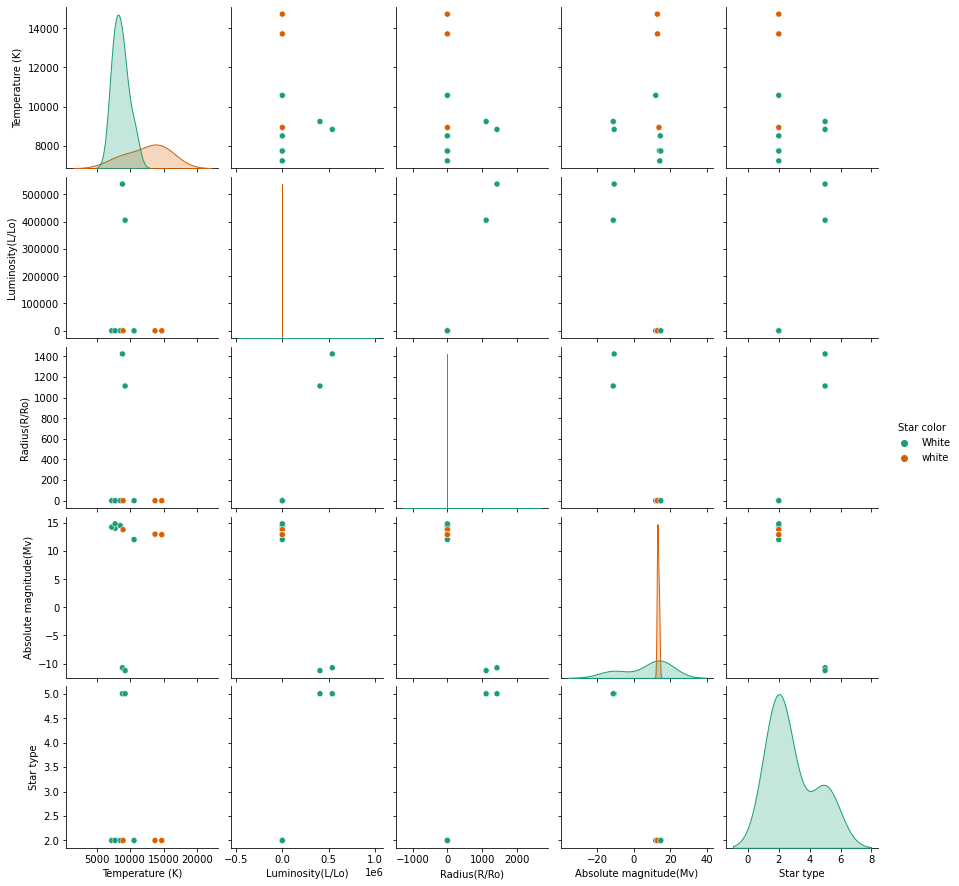

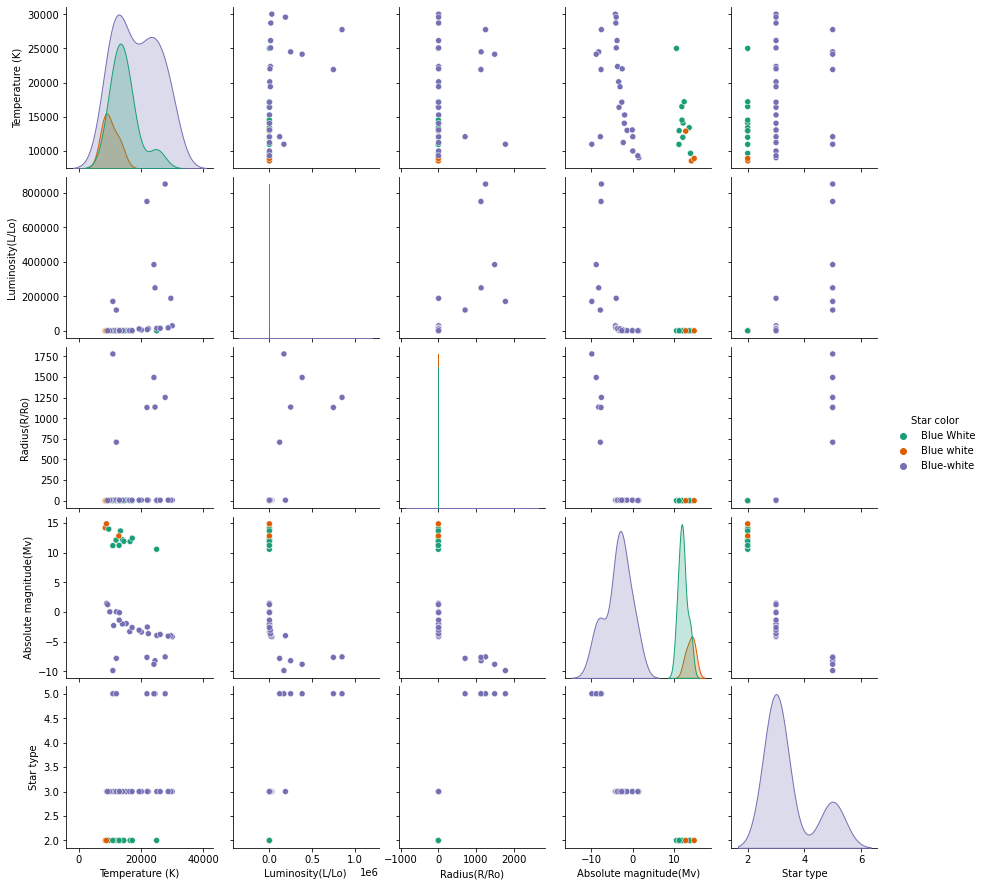

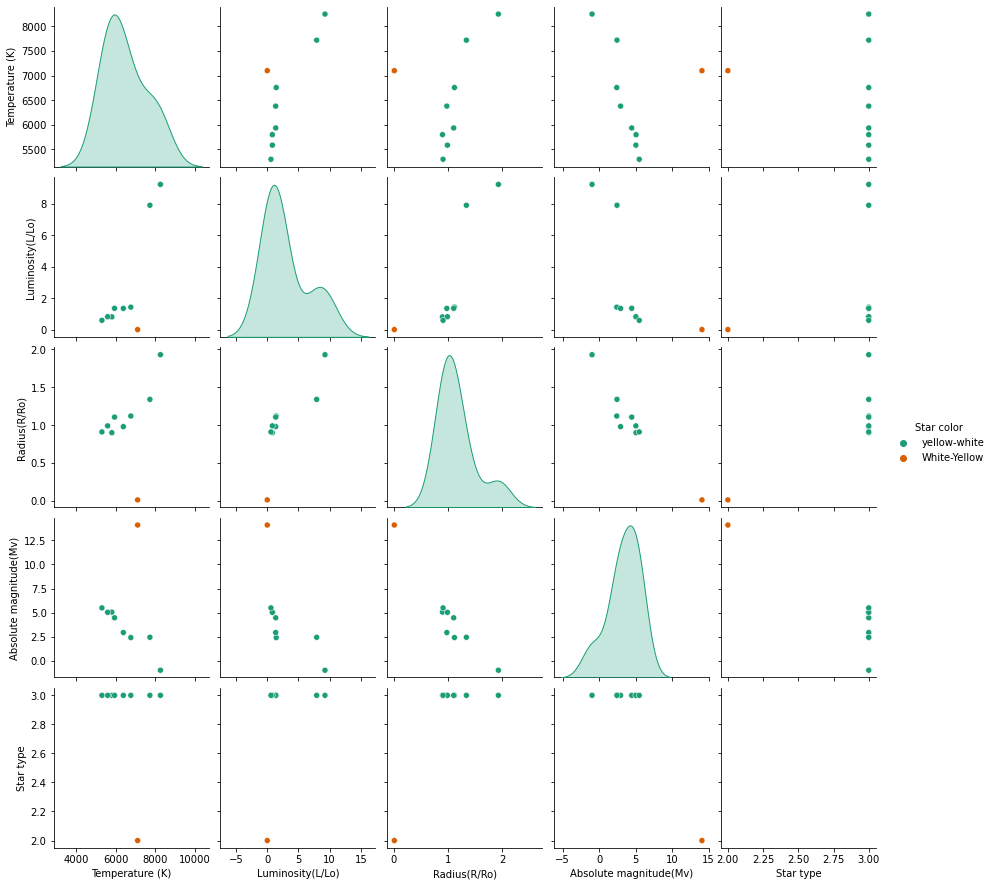

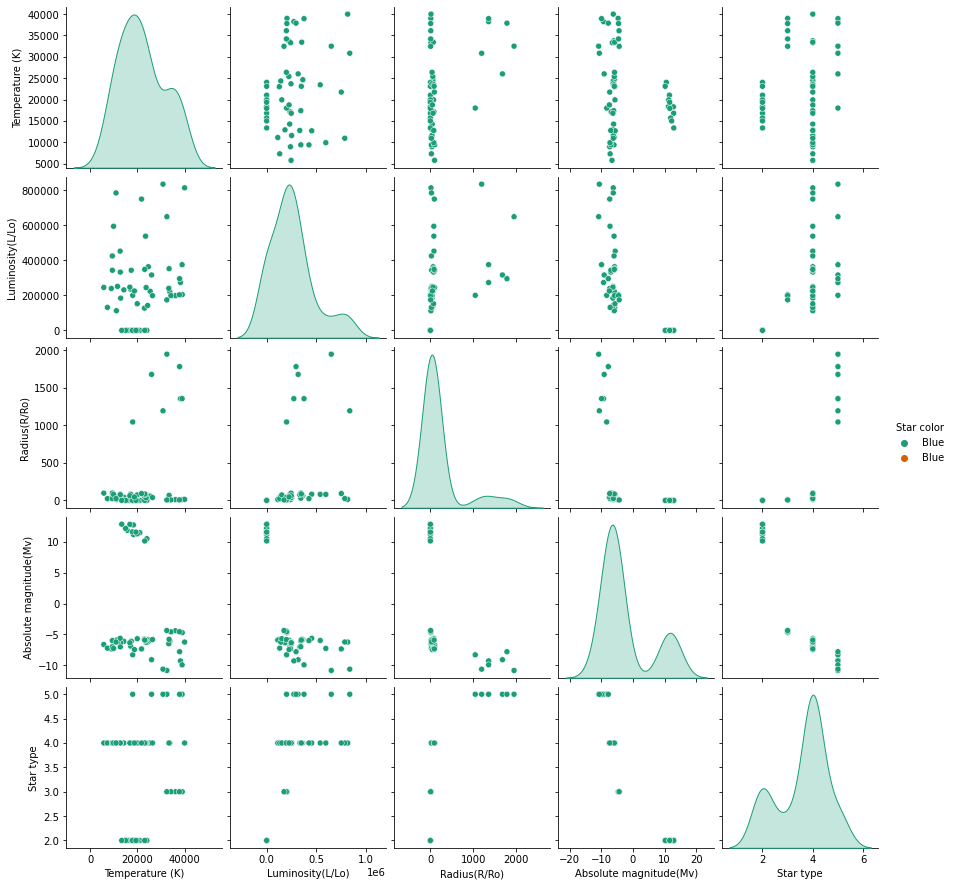

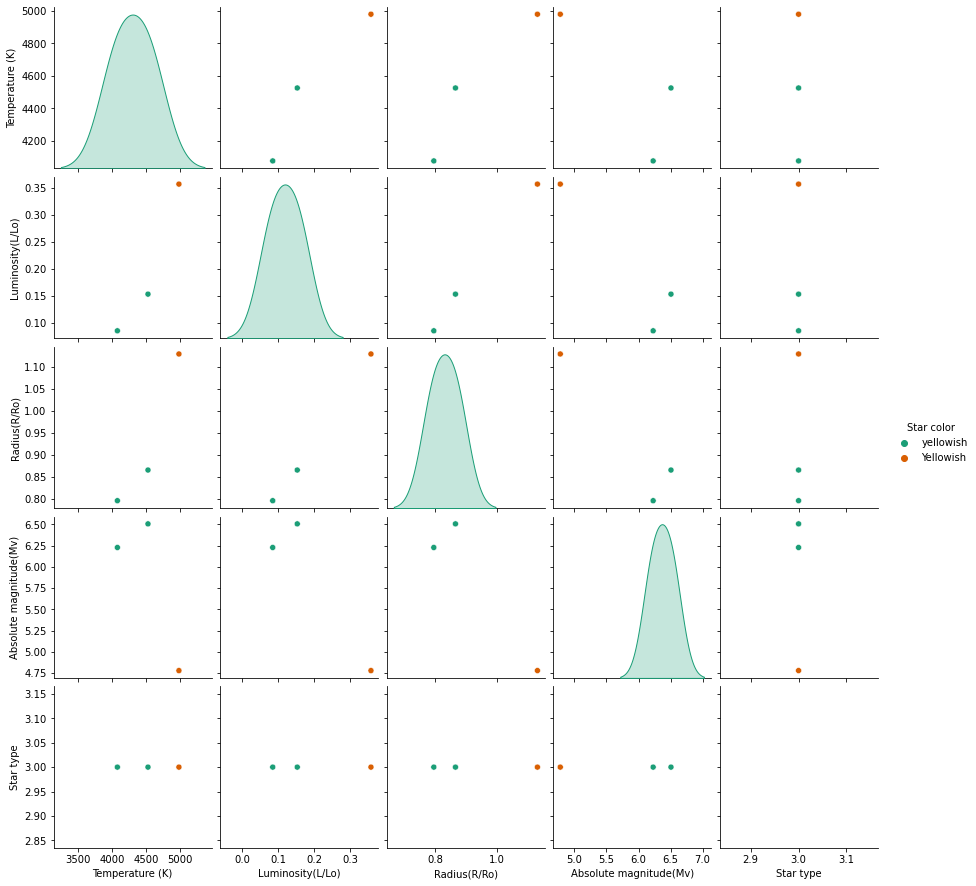

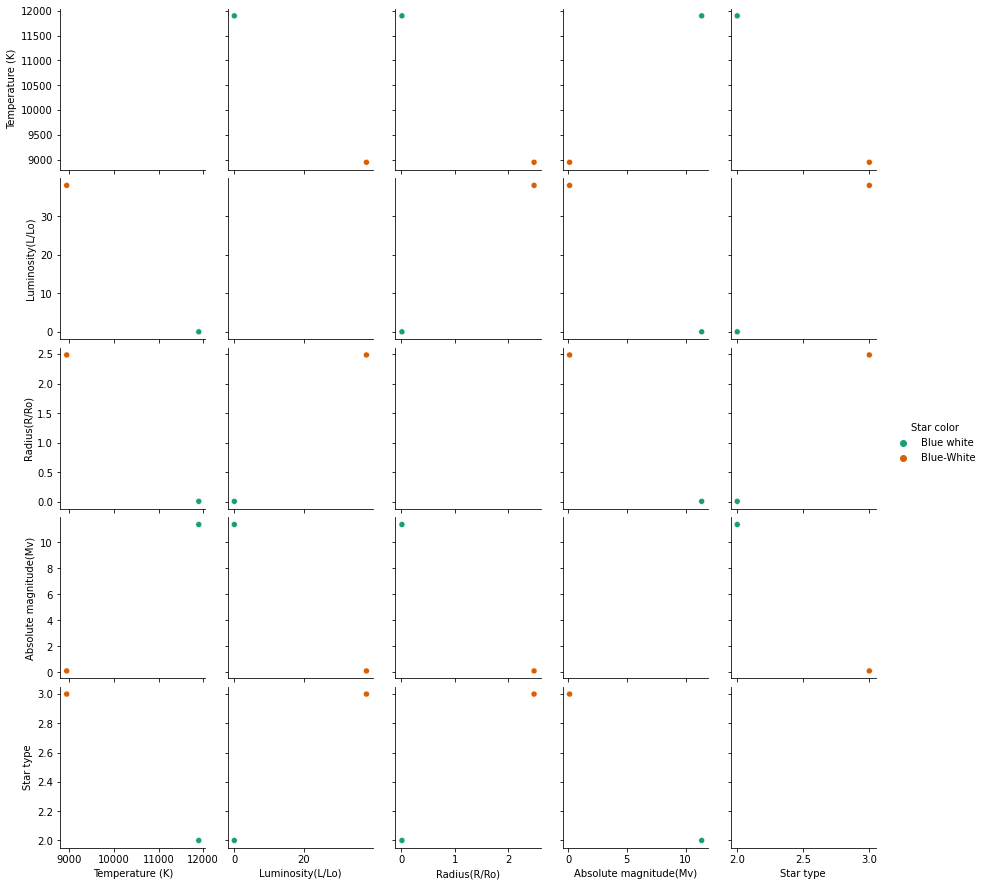

In [13]:
stars_white=stars_raw.copy()
stars_white=stars_white[stars_white['Star color'].isin(['White', 'white'])]
stars_white = stars_white.drop(columns =['Spectral Class'])
stars_white.head()
sns.pairplot(stars_white, hue='Star color', palette='Dark2')

stars_blue_white=stars_raw.copy()
stars_blue_white=stars_blue_white[stars_blue_white['Star color'].isin(['Blue-white', 'Blue White', 'Blue white'])]
stars_blue_white = stars_blue_white.drop(columns =['Spectral Class'])
sns.pairplot(stars_blue_white, hue='Star color', palette='Dark2')

stars_white_yellow=stars_raw.copy()
stars_white_yellow=stars_white_yellow[stars_white_yellow['Star color'].isin(['White-Yellow', 'yellow-white'])]
stars_white_yellow = stars_white_yellow.drop(columns =['Spectral Class'])
stars_white_yellow.head()
sns.pairplot(stars_white_yellow, hue='Star color', palette='Dark2')

stars_blue=stars_raw.copy()
stars_blue=stars_blue[stars_blue['Star color'].isin(['Blue ', 'Blue'])]
stars_blue = stars_blue.drop(columns =['Spectral Class'])
stars_blue.head()
sns.pairplot(stars_blue, hue='Star color', palette='Dark2')

stars_yellowish=stars_raw.copy()
stars_yellowish=stars_yellowish[stars_yellowish['Star color'].isin(['yellowish', 'Yellowish'])]
stars_yellowish = stars_yellowish.drop(columns =['Spectral Class'])
stars_yellowish.head()
sns.pairplot(stars_yellowish, hue='Star color', palette='Dark2')

stars_blue_white=stars_raw.copy()
stars_blue_white=stars_blue_white[stars_blue_white['Star color'].isin(['Blue white ', 'Blue-White'])]
stars_blue_white = stars_blue_white.drop(columns =['Spectral Class'])
stars_blue_white.head()
sns.pairplot(stars_blue_white, hue='Star color', palette='Dark2')

Po zwizualizowaniu gwaizd wraz z ich parametrami opisowymi można zauważyć że kolory choć z pozoru mają takie same znaczenie jednak opisują inne rodzaje gwiazd należących do innych pasm. Z tego powodu decyduje się na połącznie tylko tych kolorów dla których nie jestem w stanie stwierdzić że opisują oddzielne grupy gwaizd.
* Kolory white i White można połączyć ponieważ nie da się stwierdzić znaczących różnic pomiędzy nimi.
* Kolory Blue white oraz Blue White opisują białe karły i wyraźnie różnią się od Blue-White które opisuje reszte spektrum gwaizd mających ten kolor. Dlatego uznałem ze połącznie Blue white oraz Blue White nie będzie powodowało błędów w dalszej analizie.
* Podobna sytuacja pojawia się dla yellow-white oraz White-Yellow. Drugi kolor opisuje białego karła a pierwszy całą resztę spketrum gwiazd w tym kolorze, dlatego rezygnuję z połączenia tych dwóch kolorów. 
* Dla sytuacji Blue i Blue poamrańczowa kropka zlewa się z niebieskimi, dlatego tą spację w nazwie koloru uznaję jako błąd i decyduję się na połączenie tych dwóch barw. 
* Dla kolorów yellowish oraz Yellowish oba opisują gwiazdy w głównym paśmie, choć na wykresach te dwa zbiory są wyraźnie oddzielne od siebie to jest to spowodowane małą podziałką skali a odległości są stosunkowo małe patrząc na ogół skali gwiezdnej. Dletego decyduję się na połącznie tych dwóch barw. 
* Natomiast Blue white i Blue-White opisują dwie skrajnie różne gwaizdy. Blue white opisuje białego karła natomiast Blue-White opisuje gwiazdę z głównego pasma. Dlatego nie łączę tych dwóch kolorów.

In [4]:
stars_raw['Star color'].replace({'white' : 'White'}, inplace=True)
stars_raw['Star color'].replace({'Blue white ': 'Blue White'}, inplace=True)
stars_raw['Star color'].replace({'Blue ' : 'Blue'}, inplace=True)
stars_raw['Star color'].replace({'yellowish' : 'Yellowish'}, inplace=True)

### Zmiana atrybutów kategorycznych na ilościowe

Klassyfikatory, które zostaną użyte w dalszej części nie akceptują danych kategorycznych. Rozwiązaniem tego problemu jest zamiana wszystkich atrybutów kategorycznych (kolor gwiazd oraz klasa spektralna) na atrybuty ilościowe.

In [15]:
encoder = OrdinalEncoder()
stars_des[['Star color', 'Spectral class']] = encoder.fit_transform(stars_des[['Star color', 'Spectral class']])
stars_des.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature(K)          240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star color              240 non-null    float64
 5   Spectral class          240 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 11.4 KB


Użyty został OrdinalEncoder z pakietu sklearn.preprocessing (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Jego działanie jest dosyć proste - zamienia znaki / łańcuchy znaków reprezentujące kategorie na kolejne liczby. Np. kolor 'Red' zostanie zamieniony na 1, kolor 'White' na 2, itp.

Poniżej wypisane są nowe wartości w kolumnach 'Star color' i 'Spectral class'

In [16]:
print('Star color:', np.sort(stars_des['Star color'].unique()))
print('Spectral class:', np.sort(stars_des['Spectral class'].unique()))

Star color: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]
Spectral class: [0. 1. 2. 3. 4. 5. 6.]


### Sprawdzenie korelacji atrybutów

Jeżeli okaże się, że któreś atrybuty posiadają dużą korelacje, możlwe będzie usunięcie części z nich w celu uproszczenia danych dla modelu.

<AxesSubplot:>

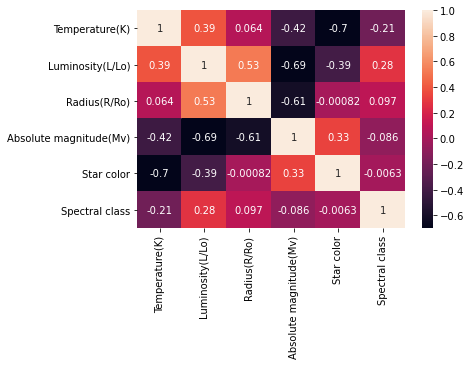

In [17]:
sns.heatmap(stars_des.corr(), annot=True)

Żadne atrybuty opisowe nie posiadają między sobą większej korelacji w zakresie całego zbioru. Największa korelacja występuje pomiędzy temperaturą, a kolorem gwiazdy (ma to sens, gdyż kolor ciała zależy od jego temperatury https://pl.wikipedia.org/wiki/Cia%C5%82o_doskonale_czarne). Jednak wartość -0.7 jest zbyt mała, żeby pozbyć się jednej z kolumn.

### Sprawdzanie korelacji poszczególnych wartości atrybutów w poszczególnych ciągów

Podczas wstępnego opsiania obiektów zauważyłem kilka prawdopodobnych korelacji które uznałem że warto sprawdzić. Także z astrofizyki wynikają pewne zależości które chciałbym potwierdzić na badanych danych. Klasa spektralna jest głównym źródłem danych o gwiazdach. Ponieważ klasa spektralna jest zależna nie liniowo z welkością, kolorem oraz temperatur. Próba porównania za pomocą heat mapy czy jakiejkolwiek innej zależności matematycznej jest chybiona. Porównanie bezpośrednie całego zbioru jest także chybione ze względu na fakt że każda klasa obiektów polega na innych zjawiskach astrofizycznych. Dlatego przeprowadzę analizę w podzbiorach które polegają na takich zjawiskach fizycznych. Dla lepszej reprezentacji można zamienię 
* Kolor - typ giwazdy
* Wielkość a nadolbrzymy
* Klasa spektralna jako wyznacznik reszty (lepiej podstawić i powinno coś ciekawego wyjść) https://pl.wikipedia.org/wiki/Typ_widmowy
* Wielkość - karły


#### Klasa spektralna

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 6
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         5 non-null      float64
 1   Luminosity(L/Lo)        5 non-null      float64
 2   Radius(R/Ro)            5 non-null      float64
 3   Absolute magnitude(Mv)  5 non-null      float64
dtypes: float64(4)
memory usage: 200.0 bytes


<AxesSubplot:xlabel='Spectral Class'>

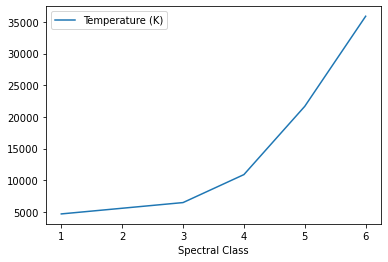

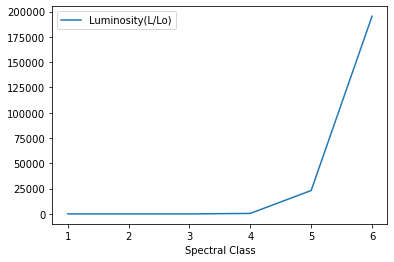

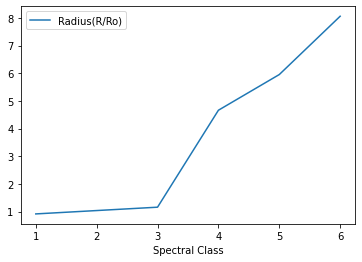

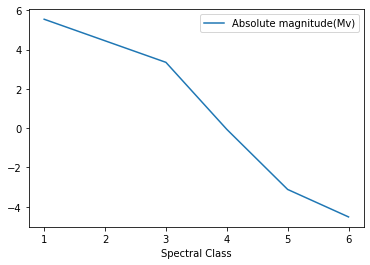

In [50]:
stars_spectral=stars_raw.copy()
stars_spectral=stars_spectral.loc[stars_spectral['Star type'] == 3]
stars_spectral=stars_spectral.drop(columns=['Star type', 'Star color'])
stars_spectral['Spectral Class'].replace({'M' : '0'}, inplace=True)
stars_spectral['Spectral Class'].replace({'K' : '1'}, inplace=True)
stars_spectral['Spectral Class'].replace({'G' : '2'}, inplace=True)
stars_spectral['Spectral Class'].replace({'F' : '3'}, inplace=True)
stars_spectral['Spectral Class'].replace({'A' : '4'}, inplace=True)
stars_spectral['Spectral Class'].replace({'B' : '5'}, inplace=True)
stars_spectral['Spectral Class'].replace({'O' : '6'}, inplace=True)
stars_spectral.astype({"Spectral Class" : int})
convert_dict = {'Spectral Class':int}
stars_spectral = stars_spectral.astype(convert_dict)
stars_spectral = stars_spectral.groupby(['Spectral Class']).mean()
stars_spectral.info()
stars_spectral[['Temperature (K)']].plot()
stars_spectral[['Luminosity(L/Lo)']].plot()
stars_spectral[['Radius(R/Ro)']].plot()
stars_spectral[['Absolute magnitude(Mv)']].plot()


#### Ciąg karłów

<AxesSubplot:>

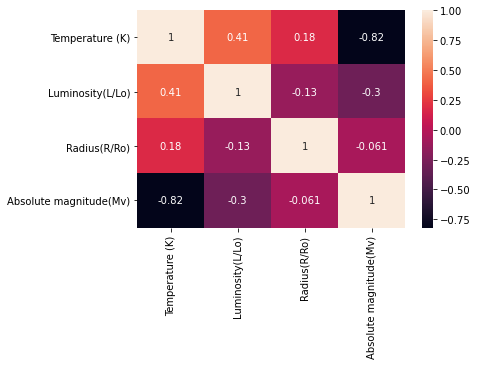

In [19]:
stars_dwarf=stars_raw.copy()
stars_dwarf=stars_dwarf.loc[stars_dwarf['Star type'] == 2]
stars_dwarf=stars_dwarf.drop(columns=['Star type'])
sns.heatmap(stars_dwarf.corr(), annot=True)

#### Ciąg główny

<AxesSubplot:>

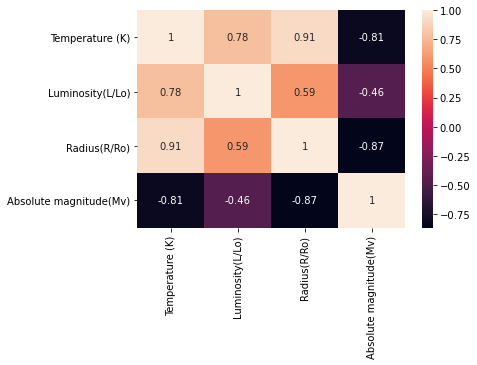

In [53]:
stars_main=stars_raw.copy()
stars_main=stars_main.loc[stars_main['Star type'] <4 ]
stars_main=stars_main.loc[stars_main['Star type'] != 2]
stars_main=stars_main.drop(columns=['Star type'])
sns.heatmap(stars_main.corr(), annot=True)

#### Ciąg olbrzymów

### Atrybuty decyzyjne

### Skalowanie danych

Dane w zbiorze posiadają różne przedziały wielkości. Aby ulepszyć działanie modelu należy wcześniej przeskalować wszystkie atrybuty, aby każdy z nich miał podobny wpływ na wynik przewidywania typu gwiazdy.

[Text(0, 0, 'Temperature(K)'),
 Text(1, 0, 'Luminosity(L/Lo)'),
 Text(2, 0, 'Radius(R/Ro)'),
 Text(3, 0, 'Absolute magnitude(Mv)'),
 Text(4, 0, 'Star color'),
 Text(5, 0, 'Spectral class')]

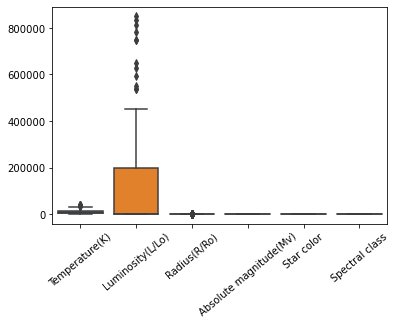

In [18]:
plot = sns.boxplot(data=stars_des)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40)

Wartości posiadają różne zakresy. Do ich przeskalowania zostanie użyty StandardScaler z pakietu sklearn.preprocessing (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Normalizuje on wszystkie kolumhy na podstawie ich wartości średniej i odchylenia standardowego wegług wzoru: nowa_wartość = (obecna_wartość - średnia) / odchylenie.

<AxesSubplot:>

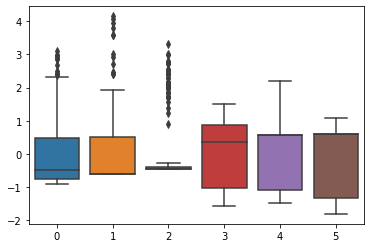

In [19]:
scaler = StandardScaler()
stars_des = scaler.fit_transform(stars_des)
sns.boxplot(data=stars_des)

Po przeskalowaniu dane mają podobne zakresy wartości.

### Podział danych na treningowe i testowe

Do sprawdzenia poprawności działania modelu potrzebny będzie zestaw danych testowych. Z racji tego, że dysponujemy jedynie 240 rekordami, podzielymy je w taki sposób, że 40 zostanie użyte do testowania, a 200 do treningu (proporcja 16,66%). Podział jest losowy, dlatego przydział obiektów do podzbiorów będzie się różnił w kolejnych uruchomieniach kodu.

In [20]:
def podzielDane():
    global stars_des_train
    global stars_des_test
    global stars_dec_train
    global stars_dec_test
    stars_des_train, stars_des_test, stars_dec_train, stars_dec_test = train_test_split(stars_des, stars_dec, test_size=0.1666)

## Porównanie modelów różnych klasyfikatorów

W celu sprawdzenia najlepszej metody klasyfikacji, wykorzystamy kilka klasyfikatorów z różnymi parametrami: k-NN, prototypów, Bayesa oraz drzew decyzyjnych. Każdy klasyfikator jest testowany wiele razy (iterationCount). Za każdym razem dane są od nowa mieszane i dzielone na zestawy treningowe i testowe. Dzięki temu w każdej iteracji testów klasyfikator dostanie trochę inne dane.

### Klasyfikator najbliższych sąsiadów (k-NN)

In [21]:
iterationCount = 50
kCount = 20
trainScores = [[0 for x in range(iterationCount)] for y in range(kCount)]
testScores = [[0 for x in range(iterationCount)] for y in range(kCount)]

for i in range(iterationCount):
    podzielDane()
    for k in range(1,kCount+1):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(stars_des_train, stars_dec_train)
        trainScores[k-1][i] = model.score(stars_des_train, stars_dec_train)
        testScores[k-1][i] = model.score(stars_des_test, stars_dec_test)

for k in range(1,kCount+1):
    print(str(k) + ':\ttrening: %.3f' % np.mean(trainScores[k-1]), '\ttest: %.3f' % np.mean(testScores[k-1]))

1:	trening: 1.000 	test: 0.980
2:	trening: 0.981 	test: 0.963
3:	trening: 0.982 	test: 0.964
4:	trening: 0.968 	test: 0.961
5:	trening: 0.970 	test: 0.962
6:	trening: 0.966 	test: 0.960
7:	trening: 0.967 	test: 0.954
8:	trening: 0.966 	test: 0.952
9:	trening: 0.961 	test: 0.948
10:	trening: 0.960 	test: 0.946
11:	trening: 0.951 	test: 0.946
12:	trening: 0.950 	test: 0.941
13:	trening: 0.950 	test: 0.940
14:	trening: 0.945 	test: 0.936
15:	trening: 0.943 	test: 0.932
16:	trening: 0.937 	test: 0.921
17:	trening: 0.931 	test: 0.914
18:	trening: 0.925 	test: 0.899
19:	trening: 0.920 	test: 0.890
20:	trening: 0.905 	test: 0.872


Klasyfikator k-NN osiągnął dosyć dobre wyniki dla mniejszych k. Był on testowany dla zakresu parametru k wynoszącego: od 1 do 20. Dla k=1 celność modelu jest najwyższa i wynosi: dla danych treningowych - 1.00; dla danych testowych - 0.98. Wzraz ze wzrostem parametru k, celność zaczyna spadać.

### Klasyfikator prototypów

In [22]:
iterationCount = 200
trainScores = [0 for x in range(iterationCount)]
testScores = [0 for x in range(iterationCount)]

for i in range(iterationCount):
    podzielDane()
    model = NearestCentroid()
    model.fit(stars_des_train, stars_dec_train)
    trainScores[i] = model.score(stars_des_train, stars_dec_train)
    testScores[i] = model.score(stars_des_test, stars_dec_test)

print('trening: %.3f' % np.mean(trainScores), '\ttest: %.3f' % np.mean(testScores))

trening: 0.895 	test: 0.883


Klasyfikator prototypów okazał się być na razie najgorszym klasyfikatorem. Po 200 iteracjach testów osiągnął on celność wynoszącą tylko: trening - 0.90; test - 0.88. Są do słabe wyniki w zestawieniu z innymi klasyfikatorami.

### Klasyfikator Bayesa

In [23]:
iterationCount = 200
trainScores = [0 for x in range(iterationCount)]
testScores = [0 for x in range(iterationCount)]

for i in range(iterationCount):
    podzielDane()
    model = GaussianNB()
    model.fit(stars_des_train, stars_dec_train)
    trainScores[i] = model.score(stars_des_train, stars_dec_train)
    testScores[i] = model.score(stars_des_test, stars_dec_test)

print('trening: %.3f' % np.mean(trainScores), '\ttest: %.3f' % np.mean(testScores))

trening: 0.986 	test: 0.975


Naiwny klasyfikator Bayesa jest dość dobry dla tego zestawu danych. Osiągną on celność podobną do klasyfikatora najbliższych sąsiadów (k=1). Jego przewagą jest to, że jest on znacznie szybszy od innych klasyfikatorów.

### Klasyfikator drzew decyzyjnych

In [24]:
iterationCount = 100
depthCount = 30
trainScores = [[0 for x in range(iterationCount)] for y in range(depthCount)]
testScores = [[0 for x in range(iterationCount)] for y in range(depthCount)]

for i in range(iterationCount):
    podzielDane()
    for d in range(1,depthCount+1):
        model = tree.DecisionTreeClassifier(max_depth=d)
        model.fit(stars_des_train, stars_dec_train)
        trainScores[d-1][i] = model.score(stars_des_train, stars_dec_train)
        testScores[d-1][i] = model.score(stars_des_test, stars_dec_test)

for d in range(1,depthCount+1):
    print(str(d) + ':\ttrening: %.3f' % np.mean(trainScores[d-1]), '\ttest: %.3f' % np.mean(testScores[d-1]))

1:	trening: 0.354 	test: 0.231
2:	trening: 0.536 	test: 0.400
3:	trening: 0.753 	test: 0.645
4:	trening: 0.934 	test: 0.891
5:	trening: 1.000 	test: 0.997
6:	trening: 1.000 	test: 0.998
7:	trening: 1.000 	test: 0.998
8:	trening: 1.000 	test: 0.996
9:	trening: 1.000 	test: 0.998
10:	trening: 1.000 	test: 0.996
11:	trening: 1.000 	test: 0.997
12:	trening: 1.000 	test: 0.997
13:	trening: 1.000 	test: 0.998
14:	trening: 1.000 	test: 0.997
15:	trening: 1.000 	test: 0.997
16:	trening: 1.000 	test: 0.996
17:	trening: 1.000 	test: 0.998
18:	trening: 1.000 	test: 0.996
19:	trening: 1.000 	test: 0.998
20:	trening: 1.000 	test: 0.998
21:	trening: 1.000 	test: 0.998
22:	trening: 1.000 	test: 0.998
23:	trening: 1.000 	test: 0.997
24:	trening: 1.000 	test: 0.997
25:	trening: 1.000 	test: 0.997
26:	trening: 1.000 	test: 0.997
27:	trening: 1.000 	test: 0.997
28:	trening: 1.000 	test: 0.998
29:	trening: 1.000 	test: 0.996
30:	trening: 1.000 	test: 0.997


Klasyfikator drzew decyzyjnych ma najlepsze wyniki spośród wszystkich testowanych tu klasyfikatorów. Dla każdej zadanej maksymalnej głębokości większej od 5 celność predykcji na zestawie treningowym wyniosła 1.00. Celność na zestawie testowym również jest bardzo dobra - nigdy nie była mniejsza od 0.99. Skoro parametr głębokości nie ma większego wpływu na cleność predykcji od pewnego momentu, lepiej jest używać jego mniejszych wartości (np. maxDepth=8). Duża głębokość negatywnie wpływa na skomplikowanie modelu klasyfikatora, a nie daje lepszych rezultatów.

## Wnioski

- Najlepszym klasyfikatorem dla tego zestawu danych jest klasyfikator drzew decyzyjnych. Osiągną on najlepsze wyniki oraz jego trenowanie nie zajmuje dużo czasu. 
- Drugim najlepszym kalsyfikatorem jest naiwny klasyfikator Bayesa. Jest on szybki i dosyć celny. Pomimo tego, że jego wynik jest podobny do wyniku klasyfikatora k-NN (k=1), to jego proces trenowania jest znacznie szybszy.